In [1]:
import sys

sys.path.insert(0, '..')

## Setup the model area

In [2]:
from morpheus.project.types.discretization import SpatialDiscretization
from morpheus.project.types.discretization.spatial import Rotation, Grid, Crs
from morpheus.project.types.geometry import Polygon, LineString

polygon = Polygon(
  type='Polygon',
  coordinates=[[
    (13.92, 50.964),
    (13.92, 50.966),
    (13.925, 50.966),
    (13.925, 50.964),
    (13.92, 50.964)
  ]]
)

rotation = Rotation(0)

grid = Grid.cartesian_from_polygon(polygon=polygon, n_cols=100, n_rows=50, rotation=rotation)
spatial_discretization = SpatialDiscretization.from_geometry_with_grid(
  geometry=polygon,
  grid=grid,
  crs=Crs.from_str('EPSG:4326')
)

## Setup Time Discretization

In [3]:
from morpheus.project.types.discretization.time.TimeUnit import TimeUnit
from morpheus.project.types.discretization.time.Stressperiods import StartDateTime, StressPeriodCollection, \
  StressPeriod, NumberOfTimeSteps, TimeStepMultiplier, IsSteadyState
from morpheus.project.types.discretization.time import TimeDiscretization
from datetime import datetime

time_discretization = TimeDiscretization(
  start_date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
  end_date_time=StartDateTime.from_datetime(datetime(2020, 12, 31)),
  stress_periods=StressPeriodCollection([
    StressPeriod(
      start_date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
      number_of_time_steps=NumberOfTimeSteps(1),
      time_step_multiplier=TimeStepMultiplier(1),
      steady_state=IsSteadyState.yes()
    ),
  ]),
  time_unit=TimeUnit.days()
)

# Setup Model

In [4]:
from morpheus.project.types.Model import Model

model = Model.new()
model = model.with_updated_time_discretization(time_discretization)
model = model.with_updated_spatial_discretization(spatial_discretization=spatial_discretization)

In [5]:
import folium

m = folium.Map(tiles="cartodbpositron", crs="EPSG3857", zoom_start=12, location=[50.965, 13.922])
m.add_child(folium.GeoJson(polygon.as_geojson()))

m.fit_bounds(m.get_bounds())
m

# Setup general head boundaries

In [6]:
from morpheus.project.types.boundaries.GeneralHeadObservation import ObservationId, ObservationName, GeneralHeadRawDataItem, \
  GeneralHeadObservation, Stage, Conductance
from morpheus.project.types.geometry import Point
from morpheus.project.types.boundaries.Boundary import BoundaryName, BoundaryCollection
from morpheus.project.types.layers import LayerId
from morpheus.project.types.boundaries.Boundary import GeneralHeadBoundary

layers_list = [LayerId.new()]

general_head_east = GeneralHeadBoundary.from_geometry(
  name=BoundaryName('general_head_east'),
  geometry=LineString([
    (13.92499, 50.966),
    (13.92499, 50.964),
  ]),
  grid=grid,
  affected_layers=[model.layers[0].layer_id],
  observations=[
    GeneralHeadObservation(
      observation_id=ObservationId.new(),
      observation_name=ObservationName.default(),
      geometry=Point((13.92499, 50.966)),
      data=[
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
          stage=Stage.from_float(100),
          conductance=Conductance.from_float(100),
        ),
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          stage=Stage.from_float(100),
          conductance=Conductance.from_float(100),
        ),
      ]
    ),
  ]
)

general_head_west = GeneralHeadBoundary.from_geometry(
  name=BoundaryName('general_head_west'),
  geometry=LineString([
    (13.92004, 50.96401),
    (13.92004, 50.96599),
  ]),
  grid=grid,
  affected_layers=[model.layers[0].layer_id],
  observations=[
    GeneralHeadObservation(
      observation_id=ObservationId.new(),
      observation_name=ObservationName.default(),
      geometry=Point((13.92004, 50.96599)),
      data=[
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
          stage=Stage.from_float(120),
          conductance=Conductance.from_float(300),
        ),
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          stage=Stage.from_float(120),
          conductance=Conductance.from_float(300),
        ),
      ]
    ),
  ]
)

boundary_collection = BoundaryCollection.new()
boundary_collection.add_boundary(general_head_west)
boundary_collection.add_boundary(general_head_east)

model = model.with_updated_boundaries(boundaries=boundary_collection)

m.add_child(folium.GeoJson(general_head_east.as_geojson()))
m.add_child(folium.GeoJson(general_head_east.affected_cells.to_geojson(grid).as_geojson()))
for observation in general_head_east.observations:
  m.add_child(folium.GeoJson(observation.as_geojson()))

m.add_child(folium.GeoJson(general_head_west.as_geojson()))
m.add_child(folium.GeoJson(general_head_west.affected_cells.to_geojson(grid).as_geojson()))
for observation in general_head_west.observations:
  m.add_child(folium.GeoJson(observation.as_geojson()))
m.fit_bounds(m.get_bounds())
m

# Setup Head Observations

In [7]:
from morpheus.project.types.observations.Observation import HeadObservation, ObservationName, HeadObservationDataItem, \
  HeadValue, ObservationCollection

head_observation_1 = HeadObservation.from_geometry(
  geometry=Point((13.92181326103696, 50.96574333352123)),
  grid=grid,
  affected_layers=[model.layers[0].layer_id],
  name=ObservationName('HOB_1'),
  data=[
    HeadObservationDataItem(
      date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
      head_value=HeadValue.from_float(111),
    ),
    HeadObservationDataItem(
      date_time=StartDateTime.from_datetime(datetime(2020, 2, 1)),
      head_value=HeadValue.from_float(112),
    ),
    HeadObservationDataItem(
      date_time=StartDateTime.from_datetime(datetime(2020, 3, 1)),
      head_value=HeadValue.from_float(113),
    ),
    HeadObservationDataItem(
      date_time=StartDateTime.from_datetime(datetime(2020, 4, 1)),
      head_value=HeadValue.from_float(114),
    ),
    HeadObservationDataItem(
      date_time=StartDateTime.from_datetime(datetime(2020, 5, 1)),
      head_value=HeadValue.from_float(115),
    ),
  ]
)

head_observation_2 = HeadObservation.from_geometry(
  geometry=Point((13.92181326103696, 50.96440649737727)),
  grid=grid,
  affected_layers=[model.layers[0].layer_id],
  name=ObservationName('HOB_2'),
  data=[
    HeadObservationDataItem(
      date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
      head_value=HeadValue.from_float(121),
    ),
    HeadObservationDataItem(
      date_time=StartDateTime.from_datetime(datetime(2020, 2, 1)),
      head_value=HeadValue.from_float(122),
    ),
    HeadObservationDataItem(
      date_time=StartDateTime.from_datetime(datetime(2020, 3, 1)),
      head_value=HeadValue.from_float(123),
    ),
    HeadObservationDataItem(
      date_time=StartDateTime.from_datetime(datetime(2020, 4, 1)),
      head_value=HeadValue.from_float(124),
    ),
    HeadObservationDataItem(
      date_time=StartDateTime.from_datetime(datetime(2020, 5, 1)),
      head_value=HeadValue.from_float(125),
    ),
  ]
)

head_observation_3 = HeadObservation.from_geometry(
  geometry=Point((13.923994608237564, 50.96440649737727)),
  grid=grid,
  affected_layers=[model.layers[0].layer_id],
  name=ObservationName('HOB_3'),
  data=[
    HeadObservationDataItem(
      date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
      head_value=HeadValue.from_float(131),
    ),
    HeadObservationDataItem(
      date_time=StartDateTime.from_datetime(datetime(2020, 2, 1)),
      head_value=HeadValue.from_float(132),
    ),
    HeadObservationDataItem(
      date_time=StartDateTime.from_datetime(datetime(2020, 3, 1)),
      head_value=HeadValue.from_float(133),
    ),
    HeadObservationDataItem(
      date_time=StartDateTime.from_datetime(datetime(2020, 4, 1)),
      head_value=HeadValue.from_float(134),
    ),
    HeadObservationDataItem(
      date_time=StartDateTime.from_datetime(datetime(2020, 5, 1)),
      head_value=HeadValue.from_float(135),
    ),
  ]
)

observations = ObservationCollection.new()
observations.add_observation(head_observation_1)
observations.add_observation(head_observation_2)
observations.add_observation(head_observation_3)

model = model.with_updated_observations(observations=observations)

m.add_child(folium.GeoJson(head_observation_1.as_geojson()))
m.add_child(folium.GeoJson(head_observation_2.as_geojson()))
m.add_child(folium.GeoJson(head_observation_3.as_geojson()))
m.fit_bounds(m.get_bounds())
m


In [8]:
from morpheus.project.infrastructure.calculation.engines.modflow_2005.packages.HobPackageMapper import \
  calculate_observation_items

result = calculate_observation_items(model=model)
result

HeadObservationData(items=[HeadObservationItem(name='HOB_1', layer=0, row=6, column=36, time_series_data=[HeadObservationTimeSeriesItem(total_time=TotalTime(value=0.0), head_value=HeadValue(value=111)), HeadObservationTimeSeriesItem(total_time=TotalTime(value=31.0), head_value=HeadValue(value=112)), HeadObservationTimeSeriesItem(total_time=TotalTime(value=60.0), head_value=HeadValue(value=113)), HeadObservationTimeSeriesItem(total_time=TotalTime(value=91.0), head_value=HeadValue(value=114)), HeadObservationTimeSeriesItem(total_time=TotalTime(value=121.0), head_value=HeadValue(value=115))]), HeadObservationItem(name='HOB_2', layer=0, row=39, column=36, time_series_data=[HeadObservationTimeSeriesItem(total_time=TotalTime(value=0.0), head_value=HeadValue(value=121)), HeadObservationTimeSeriesItem(total_time=TotalTime(value=31.0), head_value=HeadValue(value=122)), HeadObservationTimeSeriesItem(total_time=TotalTime(value=60.0), head_value=HeadValue(value=123)), HeadObservationTimeSeriesItem

## Calculate

In [9]:
from morpheus.project.types.calculation.CalculationProfile import CalculationProfile, CalculationEngineType
from morpheus.project.types.calculation.Calculation import Calculation

calculation_profile = CalculationProfile.new(CalculationEngineType.MF2005)
calculation = Calculation.new(model=model, calculation_profile=calculation_profile)

In [10]:
calculation = Calculation.from_dict(calculation.to_dict())
calculation.calculation_id

CalculationId(value='0271a711-f395-4841-ae72-569bdb420a5b')

In [11]:
from morpheus.project.infrastructure.calculation.services.CalculationService import CalculationService

calculation_service = CalculationService.from_calculation(calculation)
calculation_service.calculate()

Model(model_id=ModelId(value='afc9771c-0ce4-4a98-99ce-5379207402d5'), spatial_discretization=SpatialDiscretization(geometry=Polygon(coordinates=[[(13.92, 50.964), (13.92, 50.966), (13.925, 50.966), (13.925, 50.964), (13.92, 50.964)]], type='Polygon'), grid=Grid(origin=Point(coordinates=(13.920000000000002, 50.965999999999994), type='Point'), col_widths=[5.565974539662712, 5.565974539662712, 5.565974539662712, 5.565974539662712, 5.565974539662712, 5.565974539662712, 5.565974539662712, 5.565974539662712, 5.5659745396627045, 5.565974539662719, 5.565974539662712, 5.565974539662712, 5.5659745396627045, 5.565974539662719, 5.5659745396627045, 5.565974539662719, 5.565974539662719, 5.56597453966269, 5.565974539662719, 5.565974539662719, 5.5659745396627045, 5.565974539662719, 5.565974539662719, 5.5659745396627045, 5.5659745396627045, 5.5659745396627045, 5.565974539662733, 5.5659745396627045, 5.5659745396627045, 5.5659745396627045, 5.5659745396627045, 5.565974539662733, 5.5659745396627045, 5.5659

In [12]:
calculation_service.get_result()

CalculationResult(type=<CalculationResultType.SUCCESS: 'success'>, message='Calculation finished successfully', files=['afc9771c-0ce4-4a98-99ce-5379207402d5.pcg', 'afc9771c-0ce4-4a98-99ce-5379207402d5.hob', 'afc9771c-0ce4-4a98-99ce-5379207402d5.oc', 'afc9771c-0ce4-4a98-99ce-5379207402d5.hds', 'afc9771c-0ce4-4a98-99ce-5379207402d5.ghb', 'afc9771c-0ce4-4a98-99ce-5379207402d5.dis', 'afc9771c-0ce4-4a98-99ce-5379207402d5.nam', 'afc9771c-0ce4-4a98-99ce-5379207402d5.bas', 'afc9771c-0ce4-4a98-99ce-5379207402d5.list', 'afc9771c-0ce4-4a98-99ce-5379207402d5.lpf', 'afc9771c-0ce4-4a98-99ce-5379207402d5.hob.out'], head_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=1, number_of_observations=15), drawdown_results=None, budget_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=0, number_of_observations=0), concentration_results=None)

In [13]:
calculation_service.read_head_observations()

[Observation(name='HOB_1.1', simulated=112.727661133, observed=111.0),
 Observation(name='HOB_1.2', simulated=112.727661133, observed=112.0),
 Observation(name='HOB_1.3', simulated=112.727661133, observed=113.0),
 Observation(name='HOB_1.4', simulated=112.727661133, observed=114.0),
 Observation(name='HOB_1.5', simulated=112.727661133, observed=115.0),
 Observation(name='HOB_2.1', simulated=112.727661133, observed=121.0),
 Observation(name='HOB_2.2', simulated=112.727661133, observed=122.0),
 Observation(name='HOB_2.3', simulated=112.727661133, observed=123.0),
 Observation(name='HOB_2.4', simulated=112.727661133, observed=124.0),
 Observation(name='HOB_2.5', simulated=112.727661133, observed=125.0),
 Observation(name='HOB_3.1', simulated=104.042282104, observed=131.0),
 Observation(name='HOB_3.2', simulated=104.042282104, observed=132.0),
 Observation(name='HOB_3.3', simulated=104.042282104, observed=133.0),
 Observation(name='HOB_3.4', simulated=104.042282104, observed=134.0),
 Obser

In [14]:
head = calculation_service.read_head(0, 0)

In [15]:
import simplejson as json

json = json.dumps(head, ignore_nan=True)
json

'[[119.9990005493164, 119.7969970703125, 119.59500122070312, 119.39299774169922, 119.19100189208984, 118.98899841308594, 118.78700256347656, 118.58499908447266, 118.38300323486328, 118.18099975585938, 117.97899627685547, 117.7770004272461, 117.57499694824219, 117.37300109863281, 117.1709976196289, 116.96900177001953, 116.76699829101562, 116.56500244140625, 116.36299896240234, 116.16100311279297, 115.95899963378906, 115.75700378417969, 115.55500030517578, 115.35299682617188, 115.1510009765625, 114.94999694824219, 114.74800109863281, 114.5459976196289, 114.34400177001953, 114.14199829101562, 113.94000244140625, 113.73799896240234, 113.53600311279297, 113.33399963378906, 113.13200378417969, 112.93000030517578, 112.72799682617188, 112.5260009765625, 112.3239974975586, 112.12200164794922, 111.91999816894531, 111.71800231933594, 111.51599884033203, 111.31400299072266, 111.11199951171875, 110.91000366210938, 110.70800018310547, 110.50599670410156, 110.30400085449219, 110.10199737548828, 109.9

In [16]:
calculation_service.read_drawdown(0, 0)

[]

In [17]:
calculation_service.read_budget(0, False)

{'STORAGE_IN': 0.0,
 'CONSTANT_HEAD_IN': 0.0,
 'HEAD_DEP_BOUNDS_IN': 4682.4585,
 'TOTAL_IN': 4682.4585,
 'STORAGE_OUT': -0.0,
 'CONSTANT_HEAD_OUT': -0.0,
 'HEAD_DEP_BOUNDS_OUT': -4682.458,
 'TOTAL_OUT': -4682.458,
 'IN-OUT': 0.00048828,
 'PERCENT_DISCREPANCY': 0.0,
 'tslen': 365.0}

In [18]:
calculation_service.read_budget(0, True)

{'STORAGE_IN': 0.0,
 'CONSTANT_HEAD_IN': 0.0,
 'HEAD_DEP_BOUNDS_IN': 12.8287,
 'TOTAL_IN': 12.8287,
 'STORAGE_OUT': -0.0,
 'CONSTANT_HEAD_OUT': -0.0,
 'HEAD_DEP_BOUNDS_OUT': -12.8287,
 'TOTAL_OUT': -12.8287,
 'IN-OUT': 9.5367e-07,
 'PERCENT_DISCREPANCY': 0.0,
 'tslen': 365.0}

In [19]:
calculation_service.get_result()

CalculationResult(type=<CalculationResultType.SUCCESS: 'success'>, message='Calculation finished successfully', files=['afc9771c-0ce4-4a98-99ce-5379207402d5.pcg', 'afc9771c-0ce4-4a98-99ce-5379207402d5.hob', 'afc9771c-0ce4-4a98-99ce-5379207402d5.oc', 'afc9771c-0ce4-4a98-99ce-5379207402d5.hds', 'afc9771c-0ce4-4a98-99ce-5379207402d5.ghb', 'afc9771c-0ce4-4a98-99ce-5379207402d5.dis', 'afc9771c-0ce4-4a98-99ce-5379207402d5.nam', 'afc9771c-0ce4-4a98-99ce-5379207402d5.bas', 'afc9771c-0ce4-4a98-99ce-5379207402d5.list', 'afc9771c-0ce4-4a98-99ce-5379207402d5.lpf', 'afc9771c-0ce4-4a98-99ce-5379207402d5.hob.out'], head_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=1, number_of_observations=15), drawdown_results=None, budget_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=0, number_of_observations=0), concentration_results=None)

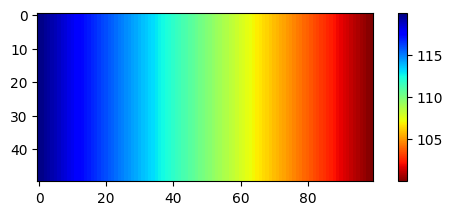

In [20]:
import matplotlib.pyplot as plt

heads = calculation_service.read_head(0, 0)
plt.subplot(2, 1, 1)
plt.imshow(heads, cmap='jet_r')
plt.colorbar()
plt.show()